<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/NLPNamedEntityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition
![alt text](https://cdn.britannica.com/55/188355-050-D5E49258/Salvatore-Corsitto-The-Godfather-Marlon-Brando-Francis.jpg)


# Setup

In [1]:
pip install transformers

     |████████████████████████████████| 778kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 32.9MB/s 
     |████████████████████████████████| 890kB 43.3MB/s 
     |████████████████████████████████| 3.0MB 30.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a19c7f5d8a62f106498a132068da0060d67571907c370293b3e5c2460c77641f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=364235bcf50439ddb45f10da6a34eb317a627d9da5b153ff211e10c6ea0c8182
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import wget
import csv
import time
import datetime
import random
import pprint as pp

from transformers import BertTokenizer
from transformers import BertForTokenClassification
from transformers import AdamW
from transformers import BertConfig
from transformers import get_linear_schedule_with_warmup

from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import SequentialSampler

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# BERT
* Fine-tuning BERT for token classification
* BERT base & uncased

![alt text](http://jalammar.github.io/images/bert-base-bert-large-encoders.png)

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# GPU

In [5]:
if torch.cuda.is_available():       
    print(f'There are {torch.cuda.device_count()} GPU(s).')
    print(f'GPU Type: {torch.cuda.get_device_name(0)}')
    device = torch.device("cuda")
else:
    print('No GPU available, using CPU.')
    device = torch.device("cpu")

There are 1 GPU(s).
GPU Type: Tesla K80


# Data
* Using the MIT Movie Task
* Formatted in BIO (or IOB) Format
* BIO = Beginning, Inside, Outside

TAG | EXAMPLE
--- | ---
ACTOR|Matt Damon
YEAR|1980s
TITLE|Pulp Fiction
GENRE|science fiction
DIRECTOR|George Lucas
SONG|Aerosmith
PLOT|Flying cars
REVIEW|must see
CHARACTER|Queen Elizabeth
RATING|PG-13
RATINGS_AVERAGE|best rated
TRAILER|preview


In [6]:
wget.download('https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio', './engtrain.bio')
wget.download('https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio',  './engtest.bio')

'./engtest.bio'

In [7]:
!ls

engtest.bio  engtrain.bio  sample_data


# Loader

In [8]:
def read_bio(file):
  """
  We read along, pushing tokens & any labels onto a local list 
  When we hit an empty line, the sentence is constructed
  Append it to the sentences & labels lists, reset tokens and continue
  """
  sentences = []
  labels = []

  # Lists to store the current iteration / sentence
  tokens = []
  token_labels = []

  with open(file, newline = '') as lines:                                                                                          
      reader = csv.reader(lines, delimiter='\t')
      for line in reader:
          if line == []:
              # Store full sentence
              sentences.append(tokens)
              labels.append(token_labels)           
      
              # Start new
              tokens = []
              token_labels = []        

          else: 
              # Append to the sentence buffer
              tokens.append(line[1])
              token_labels.append(line[0])

  return sentences, labels

In [9]:
sentences, labels = read_bio('./engtrain.bio')

In [10]:
for i in range(5):
  print(f'{" ".join(sentences[i])}')
  print(f'{" ".join(labels[i])}')
  print('\n')

what movies star bruce willis
O O O B-ACTOR I-ACTOR


show me films with drew barrymore from the 1980s
O O O O B-ACTOR I-ACTOR O O B-YEAR


what movies starred both al pacino and robert deniro
O O O O B-ACTOR I-ACTOR O B-ACTOR I-ACTOR


find me all of the movies that starred harold ramis and bill murray
O O O O O O O O B-ACTOR I-ACTOR O B-ACTOR I-ACTOR


find me a movie with a quote about baseball in it
O O O O O O O O O O O




# Tokenize

## Label to Id Index
* Create a mapping from our BIO labels to integer

In [11]:
def generate_label_index(labels):
  """
  Given a list of sentence labels (list of lists)
  Construct a dictionary mapping each label to a unique integer
  """
  unique  = set([label for sentence_labels in labels for label in sentence_labels])
  mapping = {k: v for v, k in enumerate(unique)} 
  return mapping

In [12]:
label2id = generate_label_index(labels)

In [13]:
pp.pprint(label2id)

{'B-ACTOR': 13,
 'B-CHARACTER': 2,
 'B-DIRECTOR': 3,
 'B-GENRE': 1,
 'B-PLOT': 22,
 'B-RATING': 5,
 'B-RATINGS_AVERAGE': 11,
 'B-REVIEW': 19,
 'B-SONG': 24,
 'B-TITLE': 12,
 'B-TRAILER': 20,
 'B-YEAR': 17,
 'I-ACTOR': 15,
 'I-CHARACTER': 6,
 'I-DIRECTOR': 23,
 'I-GENRE': 7,
 'I-PLOT': 8,
 'I-RATING': 4,
 'I-RATINGS_AVERAGE': 9,
 'I-REVIEW': 18,
 'I-SONG': 21,
 'I-TITLE': 10,
 'I-TRAILER': 16,
 'I-YEAR': 14,
 'O': 0}


## Apply BERT Tokens
* Encode the data for BERT

In [14]:
def tokenize(sentences):
  """
  Join sentence from token back into string for BERT
  Take in the list of sentences and use the BERT encode_plus to:
  * Add [CLS] to the start
  * Add [SEP] to the end
  * Add [PAD] to max length
  * Map any tokens to an identifier
  * Unknown tokens split using double-hash
  * Return our attention mask and pytorch tensors
  """
  input_ids = []
  attention_masks = []

  for sentence in sentences:
      text = ' '.join(sentence)
      encoded_dict = tokenizer.encode_plus(text, 
                                           add_special_tokens = True, 
                                           truncation = True,
                                           max_length = 50,  
                                           pad_to_max_length = True,
                                           return_attention_mask = True,   
                                           return_tensors = 'pt')
      
      # Append and process next sentence
      input_ids.append(encoded_dict['input_ids'][0])
      attention_masks.append(encoded_dict['attention_mask'][0])

  return input_ids, attention_masks

In [15]:
input_ids, attention_masks = tokenize(sentences)

In [16]:
pp.pprint(input_ids[2])

tensor([  101,  2054,  5691,  5652,  2119,  2632, 14397,  5740,  1998,  2728,
         7939,  9711,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [17]:
pp.pprint(attention_masks[2])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


## Apply Custom Token
* Interject our custom NER tokens into the BERT encodings

In [18]:
SPECIAL_TOKENS = [tokenizer.pad_token_id, 
                  tokenizer.cls_token_id, 
                  tokenizer.sep_token_id]
NULL_LABEL_ID  = -100

def label_sentences(input_ids, labels):
  """
  BERT will add tokens and break apart unknown tokens
  We encode these with our null indicator and label the tokens with our index
  
  For example:
  * We have the sentence: Robert Deniro
  * Our tokens are      : B-Actor, I-Actor
  * Our token map       : B-Actor : 0
                        : I-Actor : 18
  * BERT made it [CLS] Rob ##ert De ##ni ##ro [SEP] [PAD] ...
  * We need to apply our BIO tokens into the BERT tokenized list
    - Skip any special tokens BERT adds
    - Skip any ## tokens
    - Then apply our token
  * Our BERT encoded value should be -100, 0, -100, 18, -100, -100, -100 ...
  """
  new_labels = []

  for (sentence, orig_labels) in zip(input_ids, labels):
      padded_labels = []
      orig_labels_index = 0 

      for token_id in sentence:
        token_id = token_id.numpy().item()

        if token_id in SPECIAL_TOKENS or tokenizer.ids_to_tokens[token_id][0:2] == '##':  
          padded_labels.append(NULL_LABEL_ID)
        else:
          label_str = orig_labels[orig_labels_index]
          padded_labels.append(label2id[label_str])
          orig_labels_index += 1

      new_labels.append(padded_labels)

  return new_labels

In [19]:
new_labels = label_sentences(input_ids, labels)

## Example

In [20]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['what', 'movies', 'starred', 'both', 'al', 'pacino', 'and', 'robert', 'deniro']

Labels:       ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['what', 'movies', 'starred', 'both', 'al', 'pac', '##ino', 'and', 'robert', 'den', '##iro']

Token IDs:    tensor([  101,  2054,  5691,  5652,  2119,  2632, 14397,  5740,  1998,  2728,
         7939,  9711,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

New Labels:   [-100, 0, 0, 0, 0, 13, 15, -100, 0, 13, 15, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


## Tokens to Tensors

In [21]:
def tokens_to_tensors(input_ids, attention_masks, new_labels):
  """
  Create pytorch tensors of correct size to train 
  """
  pt_input_ids       = torch.stack(input_ids, dim=0)
  pt_attention_masks = torch.stack(attention_masks, dim=0)
  pt_labels          = torch.tensor(new_labels, dtype=torch.long)
  return pt_input_ids, pt_attention_masks, pt_labels

pt_input_ids, pt_attention_masks, pt_labels = \
  tokens_to_tensors(input_ids, attention_masks, new_labels)

In [22]:
print('PyTorch Tensor Input Embeddings')
print(pt_input_ids)

print('PyTorch Tensor Attention Masks')
print(pt_attention_masks)

print('PyTorch Tensor Labels')
print(pt_labels)

PyTorch Tensor Input Embeddings
tensor([[ 101, 2054, 5691,  ...,    0,    0,    0],
        [ 101, 2265, 2033,  ...,    0,    0,    0],
        [ 101, 2054, 5691,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2265, 2033,  ...,    0,    0,    0],
        [ 101, 1045, 2215,  ...,    0,    0,    0]])
PyTorch Tensor Attention Masks
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
PyTorch Tensor Labels
tensor([[-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        ...,
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100]])


# BERT & Transformers
* Images from http://jalammar.github.io/
* For our example, we're using a length of 50

![alt text](http://jalammar.github.io/images/bert-input-output.png)

![alt text](http://jalammar.github.io/images/bert-encoders-input.png)

![alt text](http://jalammar.github.io/images/t/encoder_with_tensors_2.png)

## Self-Attention 
* Query
* Key
* Value

![alt text](http://jalammar.github.io/images/t/self-attention-matrix-calculation.png)

## Output - Z

![alt text](http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

## Encoder

![alt text](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png)

# Train

## Train-Test Split

In [23]:
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

train_size = int(0.9 * len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size:,} training examples')
print(f'{val_size:,} validation examples')

8,797 training examples
978 validation examples


## Data Loaders

In [24]:
BATCH_SIZE = 32

In [25]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = BATCH_SIZE)

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = BATCH_SIZE)

## Model

In [26]:
# Load BertForTokenClassification 
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = len(label2id) + 1, 
    output_attentions = False, 
    output_hidden_states = False)

# Run model on GPU.
model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [39]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [27]:
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

In [28]:
EPOCHS = 4
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

![alt text](https://huggingface.co/transformers/_images/warmup_linear_schedule.png)

## Training Loop

In [29]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [30]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Includes refinements from Chris McCormick AI https://www.chrismccormick.ai/
seed_val = 1337

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    275.    Elapsed: 0:00:21.
  Batch    80  of    275.    Elapsed: 0:00:41.
  Batch   120  of    275.    Elapsed: 0:01:02.
  Batch   160  of    275.    Elapsed: 0:01:22.
  Batch   200  of    275.    Elapsed: 0:01:43.
  Batch   240  of    275.    Elapsed: 0:02:04.

  Average training loss: 0.43
  Training epcoh took: 0:02:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    275.    Elapsed: 0:00:21.
  Batch    80  of    275.    Elapsed: 0:00:41.
  Batch   120  of    275.    Elapsed: 0:01:02.
  Batch   160  of    275.    Elapsed: 0:01:23.
  Batch   200  of    275.    Elapsed: 0:01:43.
  Batch   240  of    275.    Elapsed: 0:02:04.

  Average training loss: 0.18
  Training epcoh took: 0:02:22

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    275.    Elapsed: 0:00:21.
  Batch    80  of    275.    Elapsed: 0:00:41.
  Batch   120  of    275.    Elapsed: 0:01:02.
  Batch   160  of    275.    Elapsed: 0:01

## Plots

Text(0.5, 0, 'Epochs')

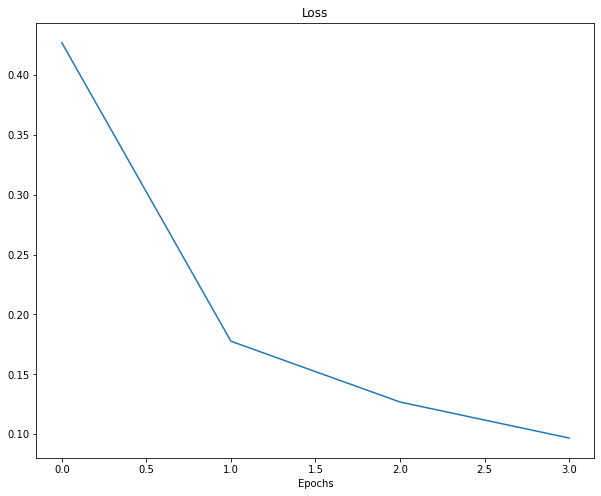

In [31]:
plt.figure(figsize=(10,8))
plt.plot(loss_values)
plt.title('Loss')
plt.xlabel('Epochs')

# Test

## Load Test 

In [32]:
test_sentences, test_labels = read_bio('./engtest.bio')
test_input_ids, test_attention_masks = tokenize(test_sentences)
test_new_labels = label_sentences(test_input_ids, test_labels)
test_pt_input_ids, test_pt_attention_masks, test_pt_labels = \
  tokens_to_tensors(test_input_ids, test_attention_masks, test_new_labels)

## Data Loaders

In [33]:
prediction_data = TensorDataset(test_pt_input_ids, test_pt_attention_masks, test_pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

## Predict

In [34]:
print(f'Predicting labels for {len(test_pt_input_ids):,} test set')

model.eval()
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack from dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Don't compute gradients
  with torch.no_grad():
      # Forward pass, calculate logits
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move predictions & labels to cpu
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 2,443 test set


## Convert
* We get a softmax of predictions per label by label type (for each sentence)
* We take the largest probability as the label
* Then flatten the sentences which gives us prediction per token

In [35]:
# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)
print(f'Predictions shape: {all_predictions.shape}')

# Pick argmax from predicted label scores
predicted_label_ids = np.argmax(all_predictions, axis=2)
print(f'Argmax shape: {predicted_label_ids.shape}')

# Eliminate axis 0, sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print(f'Flattened: {predicted_label_ids.shape}')
print(f'Ground truth: {all_true_labels.shape}')

Predictions shape: (2443, 50, 26)
Argmax shape: (2443, 50)
Flattened: (122150,)
Ground truth: (122150,)


## Filter
* Strip out predictions on BERT tokens

In [36]:
real_token_predictions = []
real_token_labels = []

for i in range(len(all_true_labels)):
    if not all_true_labels[i] == NULL_LABEL_ID:
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print(f'Before filtering : {len(all_true_labels):,}')
print(f'After filtering  : {len(real_token_labels):,}')

Before filtering : 122,150
After filtering  : 24,686


## Score
* MIT Movie Scoring

In [37]:
ivd = {v: k for k, v in label2id.items()}
friendly_labels = [ivd[i] for i in range(len(ivd))]
print(classification_report(real_token_labels, real_token_predictions, 
                            target_names=friendly_labels, zero_division=False))

                   precision    recall  f1-score   support

                O       0.97      0.98      0.97     14929
          B-GENRE       0.94      0.96      0.95      1117
      B-CHARACTER       0.66      0.68      0.67        90
       B-DIRECTOR       0.94      0.88      0.91       456
         I-RATING       0.95      0.93      0.94       226
         B-RATING       0.97      0.98      0.97       500
      I-CHARACTER       0.61      0.55      0.58        75
          I-GENRE       0.87      0.76      0.81       222
           I-PLOT       0.78      0.68      0.73       496
I-RATINGS_AVERAGE       0.88      0.92      0.90       403
          I-TITLE       0.92      0.93      0.92       856
B-RATINGS_AVERAGE       0.92      0.92      0.92       451
          B-TITLE       0.88      0.89      0.89       562
          B-ACTOR       0.92      0.95      0.94       812
           I-YEAR       0.96      0.97      0.97       610
          I-ACTOR       0.92      0.95      0.94       

# Closing
* Pre-Transformers
  * Paper 2018 https://www.aclweb.org/anthology/W18-5711.pdf
  * F1-Score : 87.41
  * BERT (Base, Uncased) : 94-95%
* Improving
  * Bigger BERT
  * More training data
  * Speed https://github.com/hanxiao/bert-as-service
* NLP Classification Tasks
  * Document
  * Sentence
  * Token
* Alternative Libraries
  * SpaCy
  * Stanford NER 
* Resources
  * http://jalammar.github.io/illustrated-bert/
  * https://www.chrismccormick.ai/
  * https://github.com/cedrickchee/awesome-bert-nlp
  * https://arxiv.org/pdf/1804.00247.pdf
  * https://www.tensorflow.org/official_models/fine_tuning_bert
  * https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
